## Toy dataset example figures

In [2]:
import os

In [807]:
import matplotlib.pyplot as plt
import proplot as pplt
from matplotlib import cm
import numpy as np
import torch
import torch.nn.functional as F
from pyro.distributions import AsymmetricLaplace

Text(0.5, 1.0, 'Y')

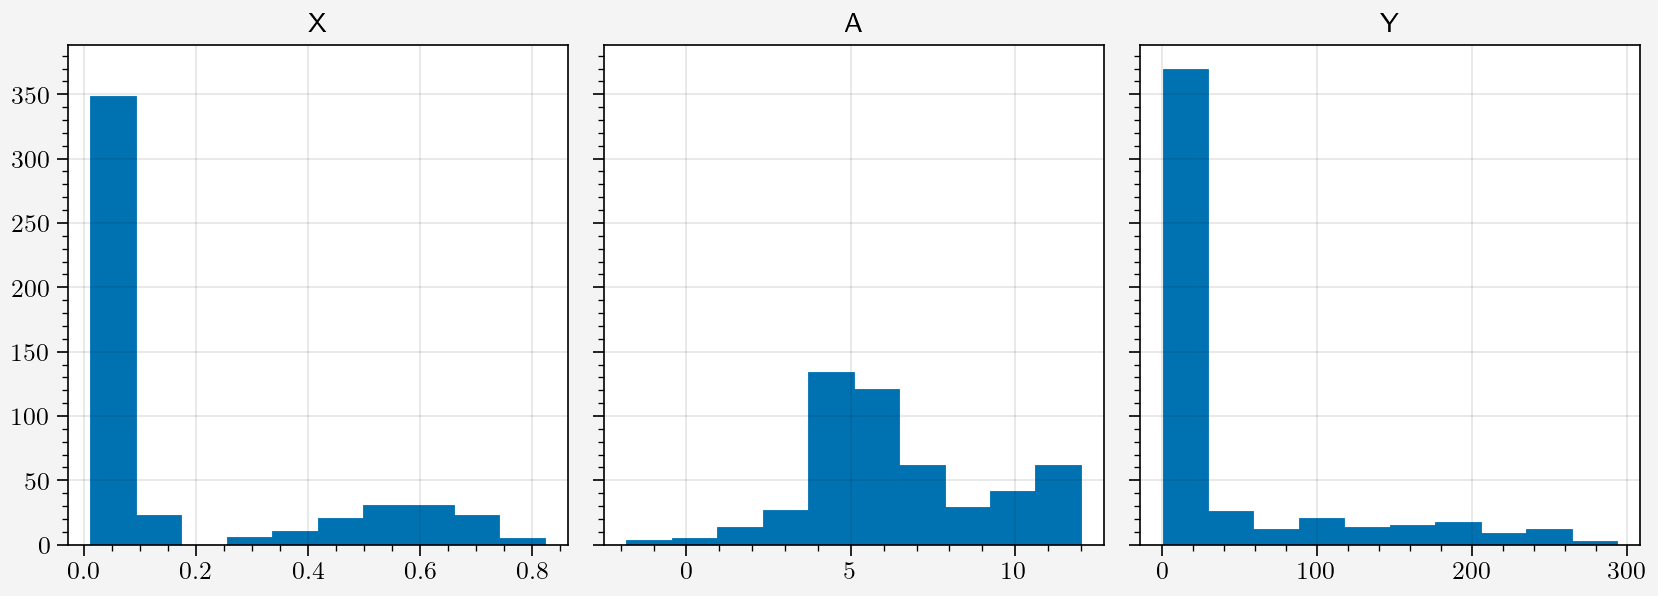

In [808]:
torch.manual_seed(110104)

N = 500  # data size
Z = (torch.rand(N) < 0.75).float() # aux latent
noise_A = torch.randn(N)
skew = 1.0
exo = 0.1
X = (Z * (-3 + 0.5 * noise_A) + (1 - Z) * (0.25 + 0.5 * noise_A)).sigmoid() # Urbanization indicator
A = 3 + 10 * AsymmetricLaplace(X.sqrt(), exo, skew).sample() # air pollution
A = A.clamp(max=12)

def gps(a: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    None

noise_Y = 5 * torch.rand(N)
f = lambda X, A, noise: (5 * X + 10 * (A - 10).sigmoid() + noise)**2
Y = f(X, A, noise_Y)

fig, ax = pplt.subplots(nrows=1, ncols=3)
ax[0].hist(X); ax[0].set_title("X")
ax[1].hist(A); ax[1].set_title("A")
ax[2].hist(Y); ax[2].set_title("Y")

Plot example dose response curves

In [1]:
nlevels = 100
Nplot = 20
# alims = [0.0, 1.0]
# alims = [A[:Nplot].min(), A[:Nplot].max() + 1]
alims = [4, 12]
# ylims = [0.0, 1.25]
A_cf = torch.linspace(*alims, nlevels)
Y_cf = f(X, A_cf[:, None], noise_Y)


NameError: name 'torch' is not defined

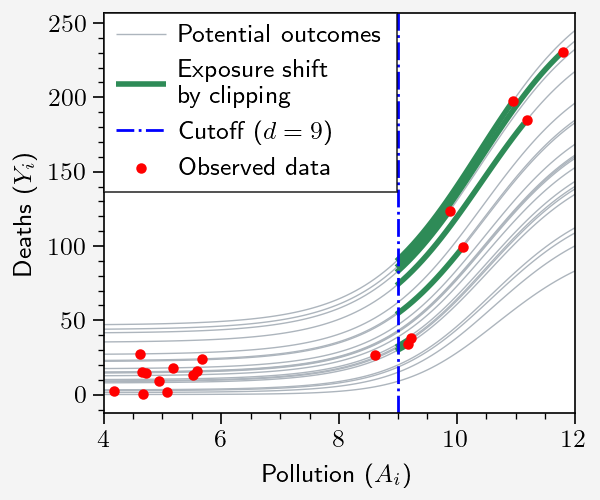

In [815]:
nlevels = 100
# alims = [0.0, 1.0]
ylims = [0.0, 1.25]
A_cf = torch.linspace(*alims, nlevels)

Y_cf = f(X, A_cf[:, None], noise_Y)

fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(3.0, 2.5))
plt.rcParams.update({"text.usetex": True})

cmap = cm.get_cmap('coolwarm', 20)
colors = cmap(X.numpy())

j1 = X[:Nplot].argmax().item()
for j in range(Nplot):
    l = ("Potential outcomes" if (j == 0) else None)
    ax.plot(A_cf, Y_cf[:, j], color="grey5", lw=0.5, label=l)


for j in range(Nplot):
    if A[j] <= A_d[j]:
        ix = (A_cf <= A_d[j]) & (A_cf >= A[j])
    else:
        ix = (A_cf <= A[j]) & (A_cf >= A_d[j])
    l = "Exposure shift\n by clipping" if j == 0 else None
    ax.plot(A_cf[ix], Y_cf[ix, j], color="seagreen", alpha=1.0, lw=2, label=l)
    # ax.scatter([A_d[j]], [Y_d[j]], color="orange", alpha=1.0, s=30, m=".")


ax.scatter(A[:Nplot], Y[:Nplot], s=10, c="red", z=3, label="Observed data")
# cb = ax.colorbar(cmap, loc="r", ticks=1, values=[0, 1], tickminor=False)
cb.set_label("Confounder ($\mathbf{X}_i$)", labelpad=-8)
ax.set_ylabel("Deaths ($Y_i$)");
ax.set_xlabel("Pollution ($A_i$)");
ax.axvline(x=d, c='blue', ls="-.", lw=1.0, label="Cutoff ($d=9$)")
ax.legend(ncols=1, loc="ul", framealpha=0.8)
# ax.set_ylim(*ylims)
ax.set_xlim(*alims)
ax.grid(False)
plt.savefig("figures/simulated_data.pdf", bbox_inches="tight", dpi=600)

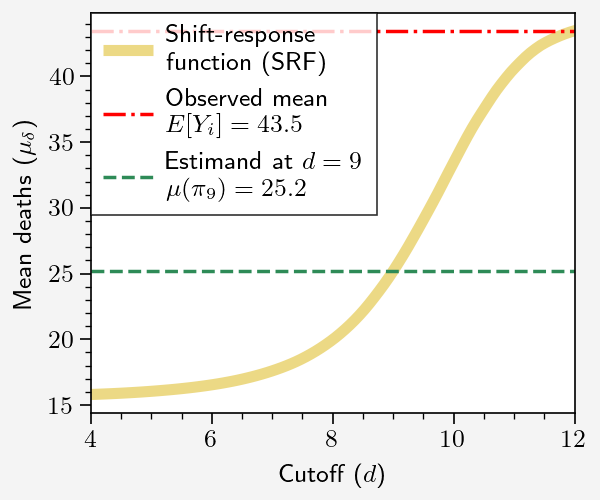

In [816]:
# dlims = (-2, 2)
dlims = (4, 12)
ds = torch.linspace(*dlims, nlevels)
# A_ds = (A[None].logit() + ds[:, None]).sigmoid()
# A_ds = (A[None] * ds[:, None])# .clamp(0, 1)
A_ds = torch.stack([A.clamp(max=d) for d in ds], 0)
Y_ds = f(X, A_ds, noise_Y)
irf = Y_ds.mean(1)

Y_d = f(X, A_d, noise_Y)

fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(3.0, 2.5))


x = ds
plt.plot(x, irf, lw=4, alpha=0.5, c="gold",  label="Shift-response\n function (SRF)")
m = Y.mean().item()

ax.axhline(y=Y.mean(), label=f"Observed mean\n $E[Y_i]={Y.mean():.1f}$", c="red", ls="-.", lw=1.25)

ax.set_ylabel("Mean deaths ($\\mu_\delta$)");
ax.set_xlabel("Cutoff ($d$)");
pi_d = "\\pi_{9}"
ax.axhline(y=Y_d.mean(), c='seagreen', ls="--", lw=1.25, label=f"Estimand at $d=9$ \n $\\mu({pi_d})={Y_d.mean():.1f}$")
ax.legend(loc="ul", ncols=1, framealpha=0.8)
ax.grid(False)
plt.savefig("figures/srf.pdf", bbox_inches="tight", dpi=600)

tensor(9.0101)


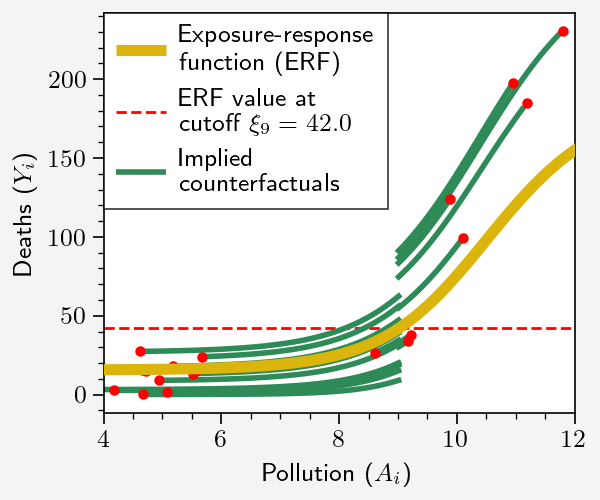

In [817]:

adrf = Y_cf.mean(1)

fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(3.0, 2.5))
j1 = X[:Nplot].argmax().item()


# k = np.where(A_cf >= A.mean())[0][0]
k = np.where(A_cf >= d)[0][0]
# k = np.where(A_cf >= 0.5)[0][0]
Ak = A_cf[k]
print(Ak)

cmap = cm.get_cmap('coolwarm', 20)
colors = cmap(X.numpy())

# j1 = X[:Nplot].argmax().item()
# for j in range(Nplot):
#     # l = ("potential outcomes" if (j == 0) else None)
#     l= None
#     ax.plot(A_cf, Y_cf[:, j], color="grey5", lw=0.5, label=l)
#     # ax.plot(A_cf, Y_cf[:, j], color=colors[j], lw=1.0, ls=(0, (1, 1)), label=l)

plt.plot(A_cf, adrf,  z=5, lw=4, alpha=1.0, c="gold", label="Exposure-response\nfunction (ERF)")


ax.scatter(A[:Nplot], Y[:Nplot], s=10, c="red", z=3)

# plt.plot(A_cf, adrf,  lw=4, alpha=0.5, c="grey5",  label="average dose-response function")

# ax.scatter([Ak], [adrf[k]], s=40, m="*", z=5, c= "purple")

adrf_val = adrf[k]

# cb.set_label("Confounder ($\mathbf{X}_i$)", labelpad=-8)
ax.set_ylabel("Deaths ($Y_i$)");
ax.set_xlabel("Pollution ($A_i$)");
# ax.axvline(x=d, c='blue', ls="-.", lw=1.0, label="Cutoff ($d=9$)")
ax.axhline(y=adrf_val, c='red', ls="--", lw=1.0, label=f"ERF value at \n cutoff $\\xi_9={adrf_val:.1f}$")

for j in range(Nplot):
    if A[j] <= Ak:
        ix = (A_cf <= Ak) & (A_cf >= A[j])
    else:
        ix = (A_cf <= A[j]) & (A_cf >= Ak)
    l = "Implied\n counterfactuals" if j == 0 else None
    ax.plot(A_cf[ix], Y_cf[ix, j], color="seagreen", alpha=1.0, lw=2.0, label=l)


ax.legend(ncols=1, loc="ul", framealpha=0.8)
ax.grid(False)
plt.xlim(*dlims)
plt.savefig("figures/erf.pdf", bbox_inches="tight", dpi=600)


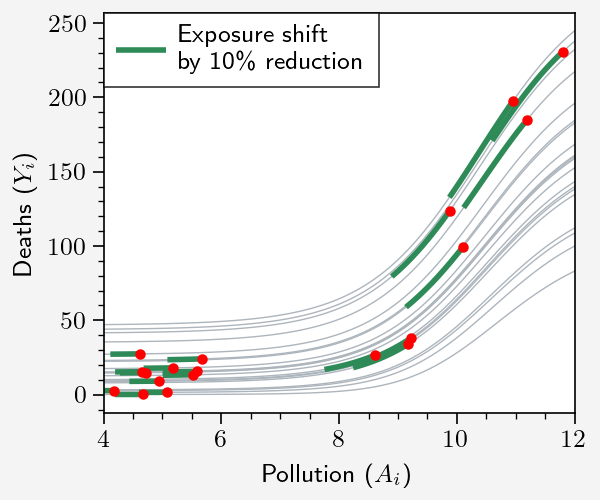

In [818]:
nlevels = 100
# alims = [0.0, 1.0]
ylims = [0.0, 1.25]
A_cf = torch.linspace(*alims, nlevels)


d = 0.1
# A_d = (A.logit() + d).sigmoid()
# A_d = (A + d).clamp(0, 1)
A_d = A * (1 - d)
# A_d = A.clamp(max=d) # .clamp(0, 1)
Y_d = f(X, A_d, noise_Y)


Y_cf = f(X, A_cf[:, None], noise_Y)

fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(3.0, 2.5))
plt.rcParams.update({"text.usetex": True})

cmap = cm.get_cmap('coolwarm', 20)
colors = cmap(X.numpy())

j1 = X[:Nplot].argmax().item()
for j in range(Nplot):
    # l = ("Potential outcomes" if (j == 0) else None)
    l = None
    ax.plot(A_cf, Y_cf[:, j], color="grey5", lw=0.5, label=l)


for j in range(Nplot):
    if A[j] <= A_d[j]:
        ix = (A_cf <= A_d[j]) & (A_cf >= A[j])
    else:
        ix = (A_cf <= A[j]) & (A_cf >= A_d[j])
    l = "Exposure shift\n by 10\% reduction" if j == 0 else None
    ax.plot(A_cf[ix], Y_cf[ix, j], color="seagreen", alpha=1.0, lw=2, label=l)
    # ax.scatter([A_d[j]], [Y_d[j]], color="orange", alpha=1.0, s=30, m=".")


# ax.scatter(A[:Nplot], Y[:Nplot], s=10, c="red", z=3, label="Observed data")
ax.scatter(A[:Nplot], Y[:Nplot], s=10, c="red", z=3)
# cb = ax.colorbar(cmap, loc="r", ticks=1, values=[0, 1], tickminor=False)
cb.set_label("Confounder ($\mathbf{X}_i$)", labelpad=-8)
ax.set_ylabel("Deaths ($Y_i$)");
ax.set_xlabel("Pollution ($A_i$)");
# ax.axvline(x=d, c='blue', ls="-.", lw=1.0, label="Cutoff ($d=9$)")
ax.legend(ncols=1, loc="ul", framealpha=0.8)
ax.set_xlim(*alims)
ax.grid(False)
plt.savefig("figures/alternative_si.pdf", bbox_inches="tight", dpi=600)